In [99]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import sys
import lightgbm as lgb
from  datetime import datetime, timedelta
from  datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [1]:
def create_train_data(train_start=750,test_start=1800,end=500,is_train=True,name=''):
    # 基本参数
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,end+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据
    price_data = pd.read_csv('sell_prices.csv',dtype=PRICE_DTYPES)
    price_data = price_data.loc[price_data.store_id == name,:]
    # 加载cal数据
    cal_data = pd.read_csv('calendar.csv',dtype=CAL_DTYPES)
    # 加载sale数据
    sale_data = pd.read_csv('sales_train_validation.csv',dtype=SALE_DTYPES,usecols=catcols+numcols)
    sale_data = sale_data.loc[sale_data.store_id == name,:]


    # 类别标签转换
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()


    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    # 注意提交格式里有一部分为空
    if not is_train:
        for day in range(end+1, end+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    return sale_data


def create_feature(sale_data, is_train=True, day=None):
    # 可以在这里加入更多的特征抽取方法
    # 获取7天前的数据，28天前的数据
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # 如果是测试集只需要计算一天的特征，减少计算量
    # 注意训练集和测试集特征生成要一致
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values  


    # 将获取7天前的数据，28天前的数据做移动平均
    wins = [7, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   

    # 处理时间特征
    # 有的时间特征没有，通过datetime的方法自动生成
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",
        }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")
    return sale_data

In [10]:
store = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3']
store_ca = ['CA_1', 'CA_2', 'CA_3', 'CA_4']
store_tx = ['TX_1', 'TX_2', 'TX_3']
store_wi = ['WI_1','WI_2', 'WI_3']

In [32]:
sale_data = create_train_data(train_start=300,end=1913,is_train=True,name='CA_1')
sale_data = create_feature(sale_data)

# 清洗数据，选择需要训练的数据
sale_data.dropna(inplace=True)

In [35]:
sale_data.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
90252,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_355,0.0,2012-01-18,11151,...,3.97,0.0,1.0,0.142857,0.857143,0.571429,0.464286,3,1,18
90253,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_356,0.0,2012-01-19,11151,...,3.97,0.0,4.0,0.142857,1.428571,0.571429,0.607143,3,1,19
90254,HOBBIES_1_002_CA_1_validation,1,0,0,0,0,d_357,0.0,2012-01-20,11151,...,3.97,0.0,2.0,0.142857,1.714286,0.571429,0.678571,3,1,20
90259,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_355,1.0,2012-01-18,11151,...,4.34,0.0,0.0,1.714286,1.000000,1.250000,1.678571,3,1,18
90260,HOBBIES_1_004_CA_1_validation,3,0,0,0,0,d_356,0.0,2012-01-19,11151,...,4.34,0.0,0.0,1.714286,0.714286,1.178571,1.642857,3,1,19


In [36]:
sale_data.date.unique()

array(['2012-01-18T00:00:00.000000000', '2012-01-19T00:00:00.000000000',
       '2012-01-20T00:00:00.000000000', ...,
       '2016-04-22T00:00:00.000000000', '2016-04-23T00:00:00.000000000',
       '2016-04-24T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
ca.append(pd.DataFrame({
        'ds':sale_data.groupby(['date'])['sales'].sum().index,
        'y':sale_data.groupby(['date'])['sales'].sum().values,
    }))

In [ ]:
ca = []
for i in store_ca:   
    sale_data = create_train_data(train_start=300,end=1913,is_train=True,name=i)
    sale_data = create_feature(sale_data)

    # 清洗数据，选择需要训练的数据
    sale_data.dropna(inplace=True)
    ca.append(pd.DataFrame({
            'ds':sale_data.groupby(['date'])['sales'].sum().index,
            'y':sale_data.groupby(['date'])['sales'].sum().values,
        }))



In [ ]:
tx = []
for i in store_tx:   
    sale_data = create_train_data(train_start=300,end=1913,is_train=True,name=i)
    sale_data = create_feature(sale_data)

    # 清洗数据，选择需要训练的数据
    sale_data.dropna(inplace=True)
    tx.append(pd.DataFrame({
            'ds':sale_data.groupby(['date'])['sales'].sum().index,
            'y':sale_data.groupby(['date'])['sales'].sum().values,
        }))



In [ ]:
wi = []
for i in store_wi:   
    sale_data = create_train_data(train_start=300,end=1913,is_train=True,name=i)
    sale_data = create_feature(sale_data)

    # 清洗数据，选择需要训练的数据
    sale_data.dropna(inplace=True)
    wi.append(pd.DataFrame({
            'ds':sale_data.groupby(['date'])['sales'].sum().index,
            'y':sale_data.groupby(['date'])['sales'].sum().values,
        }))



In [165]:
ca1 = pd.DataFrame({
        'ds':sale_data.date.values,
        'y':sale_data.sales.values,
    })

In [129]:
ca_all = []
for i in store_ca:
    ca_all.append(pd.read_csv(f"{i}_聚合.csv"))

In [130]:
tx_all = []
for i in store_tx:
    tx_all.append(pd.read_csv(f"{i}_聚合.csv"))

In [131]:
wi_all = []
for i in store_wi:
    wi_all.append(pd.read_csv(f"{i}_聚合.csv"))

In [14]:
ca = pd.read_csv('ca_date.csv').date.values
tx = pd.read_csv('tx_date.csv').date.values
wi = pd.read_csv('wi_date.csv').date.values

In [15]:
#加入节日
Snap_CA = pd.DataFrame({
  'holiday': 'Snap_CA',
  'ds': pd.to_datetime(ca),
  'lower_window': 0,
  'upper_window': 9,
})


Snap_TX = pd.DataFrame({
  'holiday': 'Snap_TX',
  'ds': pd.to_datetime(tx),
  'lower_window': 0,
  'upper_window': 0,
})

Snap_WI = pd.DataFrame({
  'holiday': 'Snap_WI',
  'ds': pd.to_datetime(wi),
  'lower_window': 0,
  'upper_window': 1,
})

Pesach_End = pd.DataFrame({
  'holiday': 'Pesach_End',
  'ds': pd.to_datetime(['2011-4-26','2012-4-14','2013-4-2','2014-4-22','2015-4-11','2016-4-30']),
  'lower_window': 0,
  'upper_window': 0,
})

OrthodoxEaster = pd.DataFrame({
  'holiday': 'OrthodoxEaster',
  'ds': pd.to_datetime(['2011-4-24','2012-4-15','2013-5-5','2014-4-20','2015-4-12','2016-5-1']),
  'lower_window': 0,
  'upper_window': 0,
})

Cinco_De_Mayo = pd.DataFrame({
  'holiday': 'Cinco_De_Mayo',
  'ds': pd.to_datetime(['2011-5-5','2012-5-5','2013-5-5','2014-5-5','2015-5-5','2016-5-5']),
  'lower_window': 0,
  'upper_window': 0,
})

Mothers_day = pd.DataFrame({
  'holiday': 'Mothers_day',
  'ds': pd.to_datetime(['2011-5-8','2012-5-13','2013-5-12','2014-5-11','2015-5-10','2016-5-8']),
  'lower_window': 0,
  'upper_window': 0,
})

NBAFinalsStart = pd.DataFrame({
  'holiday': 'NBAFinalsStart',
  'ds': pd.to_datetime(['2011-5-31','2012-6-12','2013-6-6','2014-6-5','2015-6-4','2016-6-2']),
  'lower_window': 0,
  'upper_window': 0,
})

Ramadan_starts = pd.DataFrame({
  'holiday': 'Ramadan_starts',
  'ds': pd.to_datetime(['2011-8-1','2012-7-2','2013-7-9','2014-6-29','2015-6-18','2016-6-7']),
  'lower_window': 0,
  'upper_window': 0,
})

NBAFinalsEnd = pd.DataFrame({
  'holiday': 'NBAFinalsEnd',
  'ds': pd.to_datetime(['2011-6-12','2012-6-21','2013-6-20','2014-6-15','2015-6-16','2016-6-19']),
  'lower_window': 0,
  'upper_window': 0,
})

Fathers_day = pd.DataFrame({
  'holiday': 'Fathers_day',
  'ds': pd.to_datetime(['2011-6-19','2012-6-17','2013-6-16','2014-6-15','2015-6-21','2016-6-19']),
  'lower_window': 0,
  'upper_window': 0,
})



#m = Prophet(weekly_seasonality=False)


# holiday = pd.concat((Snap_CA,Pesach_End,OrthodoxEaster,Cinco_De_Mayo,Mothers_day,NBAFinalsStart,Ramadan_starts,NBAFinalsEnd,Fathers_day))
# m = Prophet(holidays=holiday,yearly_seasonality=False,weekly_seasonality=False)

# # 加入月季节性
# m.add_seasonality(name='monthly', period=28, fourier_order=10)
# m.add_seasonality(name='weekly',  period=7, fourier_order=10)


# m.add_country_holidays(country_name='US')
# m.fit(df)
# future = m.make_future_dataframe(periods=28)
# forecast = m.predict(future)
# result.append(forecast)


#m.fit(ca1)

In [113]:
holiday_ca = pd.concat((Snap_CA,Pesach_End,OrthodoxEaster,Cinco_De_Mayo,Mothers_day,NBAFinalsStart,Ramadan_starts,NBAFinalsEnd,Fathers_day))
holiday_tx = pd.concat((Snap_TX,Pesach_End,OrthodoxEaster,Cinco_De_Mayo,Mothers_day,NBAFinalsStart,Ramadan_starts,NBAFinalsEnd,Fathers_day))
holiday_wi = pd.concat((Snap_WI,Pesach_End,OrthodoxEaster,Cinco_De_Mayo,Mothers_day,NBAFinalsStart,Ramadan_starts,NBAFinalsEnd,Fathers_day))


In [256]:
#ca1-ca4
ca_re = []
for i in ca_all:
    i.loc[i.y == 0,'y'] = np.nan
    #i['cap'] = 4000
    m = Prophet(holidays=holiday_ca,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=0.5)

    # 加入月季节性
    m.add_seasonality(name='monthly', period=28, fourier_order=10)
    m.add_seasonality(name='weekly',  period=7, fourier_order=10)
    m.add_country_holidays(country_name='US')

    m.fit(i)
    future = m.make_future_dataframe(periods=28)
    #future['cap'] = 4000
    forecast = m.predict(future)
    ca_re.append(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [282]:
#tx1-tx3
tx_re = []
for i in tx_all:
    i.loc[i.y == 0,'y'] = np.nan
    m = Prophet(holidays=holiday_tx,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=1)

    # 加入月季节性
    m.add_seasonality(name='monthly', period=28, fourier_order=10)
    m.add_seasonality(name='weekly',  period=7, fourier_order=10)
    m.add_country_holidays(country_name='US')

    m.fit(i)
    future = m.make_future_dataframe(periods=28)
    forecast = m.predict(future)
    tx_re.append(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [258]:
#wi1-wi3
wi_re = []
for i in wi_all:
    i.loc[i.y == 0,'y'] = np.nan
    m = Prophet(holidays=holiday_wi,yearly_seasonality=False,weekly_seasonality=False,changepoint_prior_scale=0.5)

    # 加入月季节性
    m.add_seasonality(name='monthly', period=28, fourier_order=10)
    m.add_seasonality(name='weekly',  period=7, fourier_order=10)
    m.add_country_holidays(country_name='US')

    m.fit(i)
    future = m.make_future_dataframe(periods=28)
    forecast = m.predict(future)
    wi_re.append(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [259]:
ca1_p = ca_re[0].yhat.values[-28:]
ca2_p = ca_re[1].yhat.values[-28:]
ca3_p = ca_re[2].yhat.values[-28:]
ca4_p = ca_re[3].yhat.values[-28:]
tx1_p = tx_re[0].yhat.values[-28:]
tx2_p = tx_re[1].yhat.values[-28:]
tx3_p = tx_re[2].yhat.values[-28:]
wi1_p = wi_re[0].yhat.values[-28:]
wi2_p = wi_re[1].yhat.values[-28:]
wi3_p = wi_re[2].yhat.values[-28:]
all_p = [ca1_p,ca2_p,ca3_p,ca4_p,tx1_p,tx2_p,tx3_p,wi1_p,wi2_p,wi3_p]

In [260]:
ca1_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/CA_1_sub_NoWeight.csv')
ca2_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/CA_2_sub_NoWeight.csv')
ca3_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/CA_3_sub_NoWeight.csv')
ca4_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/CA_4_sub_NoWeight.csv')
tx1_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/TX_1_sub_NoWeight.csv')
tx2_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/TX_2_sub_NoWeight.csv')
tx3_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/TX_3_sub_NoWeight.csv')
wi1_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/WI_1_sub_NoWeight.csv')
wi2_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/WI_2_sub_NoWeight.csv')
wi3_l = pd.read_csv('/Users/xuelei/Desktop/kaggle/m5-forecasting-accuracy/ten_model/WI_3_sub_NoWeight.csv')
all_l = [ca1_l,ca2_l,ca3_l,ca4_l,tx1_l,tx2_l,tx3_l,wi1_l,wi2_l,wi3_l]

In [261]:
res = []
for l,p in zip(all_l,all_p):
    sum_ = l.loc[:,'F1':].apply(lambda x: x.sum()).values
    w = p / sum_
    for i,W in zip(l.columns[1:],w):
        l.loc[:,i] = l.loc[:,i].apply(lambda x:x*W)
    res.append(l)


In [262]:
sub = pd.read_csv('sample_submission.csv')[30490:]
res.append(sub)
result = pd.concat(res,ignore_index=True)
result.to_csv('submission_ensemble.csv',index=False)

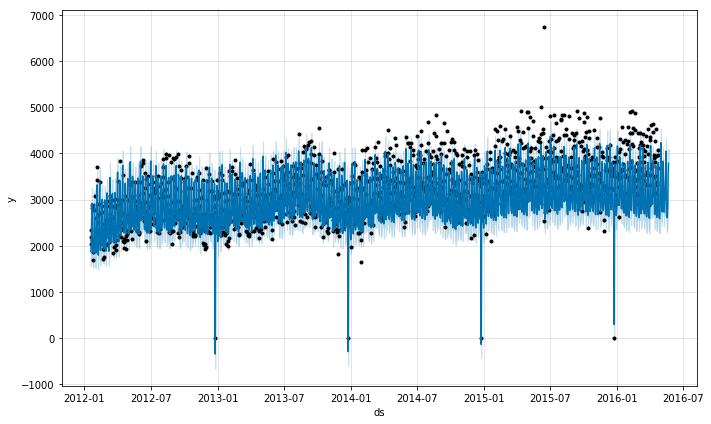

In [283]:
fig1 = m.plot(tx_re[0])

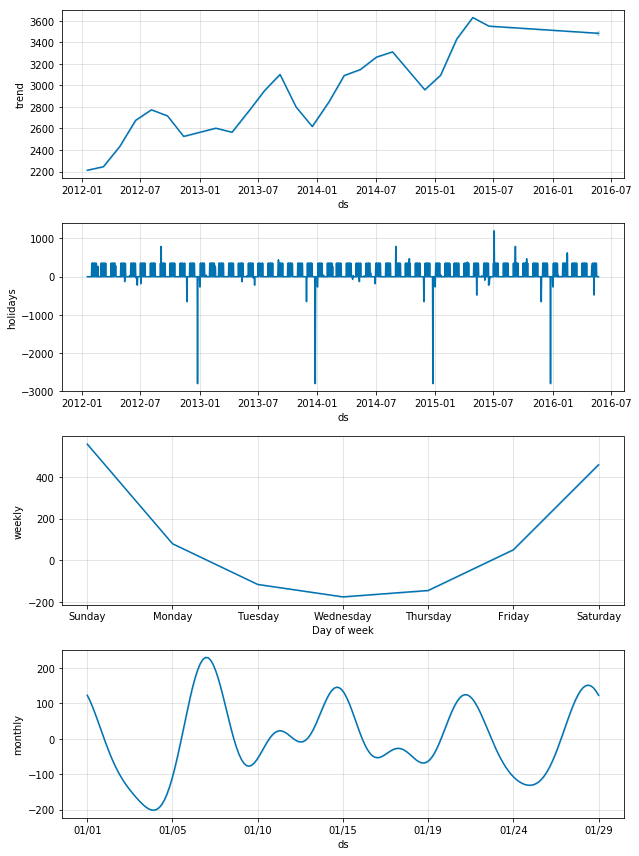

In [287]:
fig2 = m.plot_components(tx_re[2])